In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

In [3]:
import pandas as pd
import numpy as np
from statsmodels.graphics import tsaplots
from statsmodels.stats import diagnostic
from statsmodels.tsa.stattools import adfuller, kpss
import matplotlib.pyplot as plt
import scipy

from load_dataset import Dataset
import plotting

In [4]:
def test_adfuler(data):
    test = adfuller(data.dropna())
    print ('adf: ', test[0])
    print ('p-value: ', test[1])
    print ('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print ('есть единичные корни, ряд не стационарен')
    else:
        print ('единичных корней нет, ряд стационарен')

In [5]:
def extract_trend(ts: pd.Series):
    """
    Извлекает линейный тренд из временного ряда
    """
    # <ваш код здесь>
    k, b = np.polyfit(range(len(ts)), ts.values, 1)
    trend = pd.Series(k * np.array(range(len(ts))) + b, index=ts.index)
    return trend, k, b

In [6]:
def extract_seasonality(ts_detrended, period=None):
    """
    Извлекает сезонную компоненту
    """
    # <ваш код здесь>
    smoothing_window = period // 3
    season = ts_detrended.rolling(smoothing_window).median()
    return season

In [7]:
data = pd.read_csv('sbrf.csv', index_col='TRADEDATE', parse_dates=True)
data = data ['CLOSE'].dropna()

In [8]:
#создаем series с каждым днем.
data_per_day = pd.Series({'CLOSE':np.NaN}, index=pd.date_range(
                            start=data[:1].index.values[0],
                            end=data[-1:].index.values[0],
                            freq='D'))
data = data.groupby(data.index).first() #убираем дубликаты
data = data_per_day.combine_first(data) #соединяем 
data.index = pd.DatetimeIndex(data.index).to_period('D')
data.fillna(method='pad', inplace=True) #заполняем NaN предыдущими значениями

<AxesSubplot:>

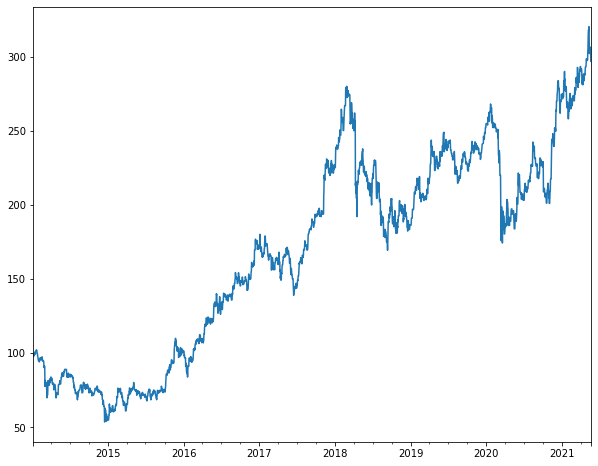

In [313]:
data.plot(figsize=(10, 8))

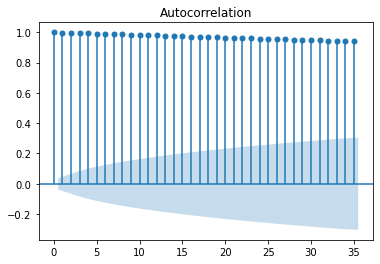

In [314]:
tsaplots.plot_acf(data);

In [315]:
# проверим ряд на стационарость критерием Дики-Фуллера
# видим, что p-value сильно выше порога, значит мы никак не можем отвергнуть нулевую гипотезу, следовательно -
# ряд не стационарен
test_adfuler(data)

adf:  -0.41721462035984397
p-value:  0.9071846326853166
Critical values:  {'1%': -3.4327814808594526, '5%': -2.8626142490094613, '10%': -2.5673418586412}
есть единичные корни, ряд не стационарен


adf:  -0.5962697476144636
p-value:  0.8718226852321915
Critical values:  {'1%': -3.433878215107907, '5%': -2.8630985090913432, '10%': -2.56759969475745}
есть единичные корни, ряд не стационарен


<AxesSubplot:xlabel='TRADEDATE'>

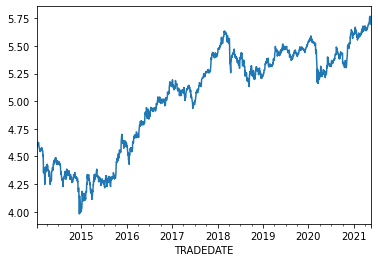

In [408]:
# Попробуем сделать его стационарным
# Для начала постараемся избавиться от гетероскедастичности, взяв логарифм
data_log = np.log(data)
test_adfuler(data_log)
data_log.plot()

adf:  -2.6126878759648293
p-value:  0.09040319327390933
Critical values:  {'1%': -3.433876312517571, '5%': -2.863097669161313, '10%': -2.567599247525482}
есть единичные корни, ряд не стационарен


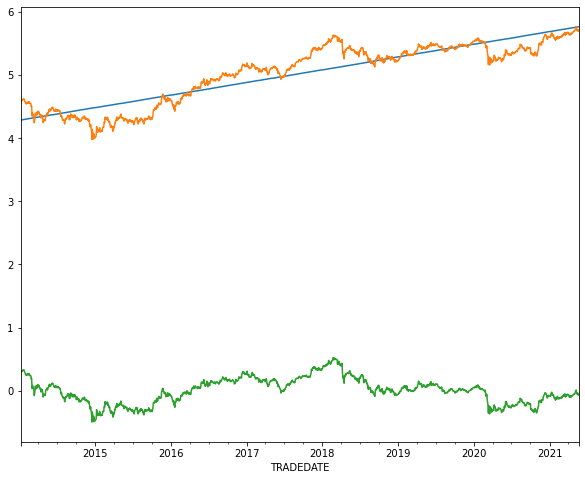

In [409]:
trend = extract_trend(data_log)[0] #data_log убрали гетероскедастичность
detrended_data = data_log - trend #вычитаем тренд из ряда
trend.plot(figsize=(10, 8))
data_log.plot(figsize=(10, 8))
detrended_data.plot(figsize=(10, 8))
test_adfuler(detrended_data) #проверяем на стационарность

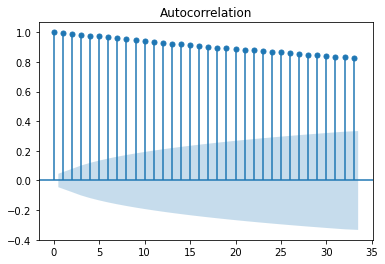

In [410]:
#сезонности нет ряд не стационарен
tsaplots.plot_acf(detrended_data);

adf:  -14.725434038887602
p-value:  2.7107501582676867e-27
Critical values:  {'1%': -3.433878215107907, '5%': -2.8630985090913432, '10%': -2.56759969475745}
единичных корней нет, ряд стационарен


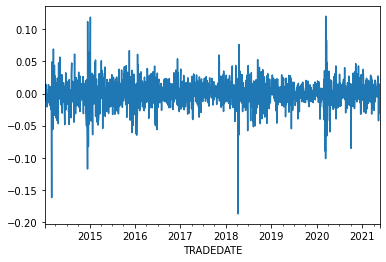

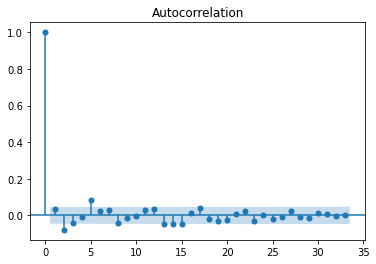

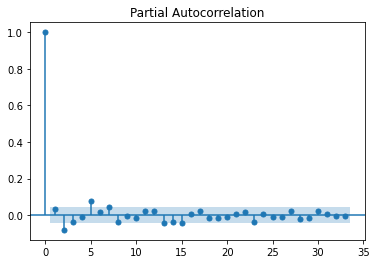

In [411]:
#делаем ряд стационарным
detrended_data_diff = detrended_data.diff().dropna()
test_adfuler(detrended_data_diff)
detrended_data_diff.plot()
tsaplots.plot_acf(detrended_data_diff)
tsaplots.plot_pacf(detrended_data_diff);
#все грустно модель ARIMA не подходит

In [412]:
#все вышесказанное в библиотеке
from statsmodels.tsa.seasonal import seasonal_decompose

In [415]:
decomp = seasonal_decompose(data, period=365)

<AxesSubplot:xlabel='TRADEDATE'>

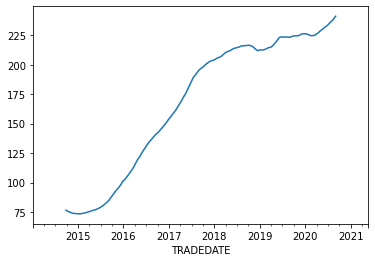

In [416]:
decomp.trend.plot()

adf:  -3.975530990191009
p-value:  0.0015441994149270652
Critical values:  {'1%': -3.4347582315402434, '5%': -2.863486949792871, '10%': -2.567806534528638}
единичных корней нет, ряд стационарен


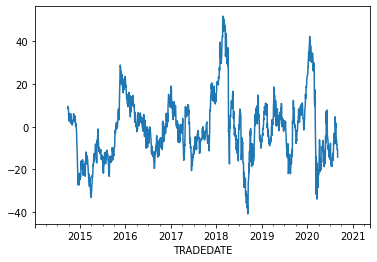

In [418]:
decomp.resid.plot()
test_adfuler(decomp.resid)

## ARIMA

In [17]:
from statsmodels.tsa.statespace import sarimax
from scipy.stats import boxcox

In [318]:
len_test = int (len(data)*0.8) #80% обучающая выборка
ts, ts_test = data[:len_test], data[len_test:]

In [319]:
ts.shape, ts_test.shape

((2154,), (539,))

<AxesSubplot:>

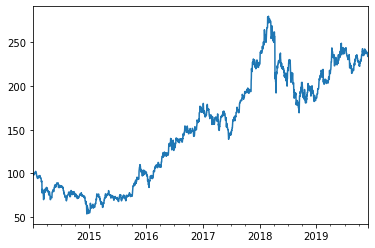

In [320]:
ts.plot()

### Вариант 1. убираем гетероскедастичность, и дифференцируем чтобы убрать тренд

<AxesSubplot:>

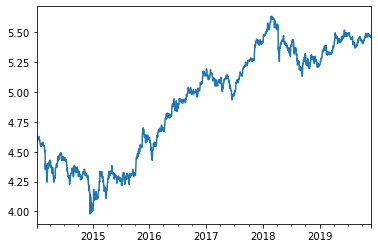

In [361]:
ts_log = np.log(ts) #убираем гетероскедастичность
ts_log.plot()

In [862]:
#Дифференцируем
ts_flat = ts_log.diff().dropna()

adf:  -16.902698023705586
p-value:  1.024809684540118e-29
Critical values:  {'1%': -3.4347582315402434, '5%': -2.863486949792871, '10%': -2.567806534528638}
единичных корней нет, ряд стационарен


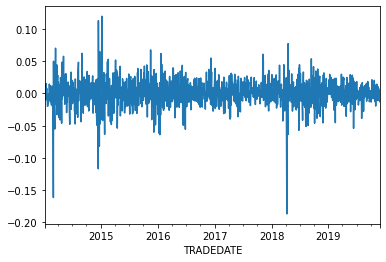

In [863]:
#получаем D,d + приверяем на стационарность
ts_flat.plot()
test_adfuler(ts_flat)

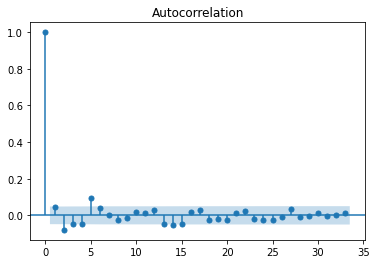

In [325]:
# проверяем на сезонность, у ряда нет сезонности
tsaplots.plot_acf(ts_flat);

### d=1

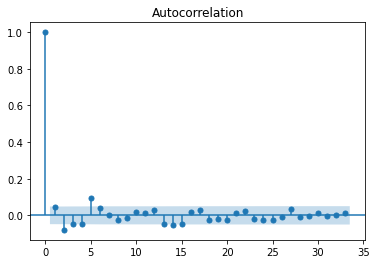

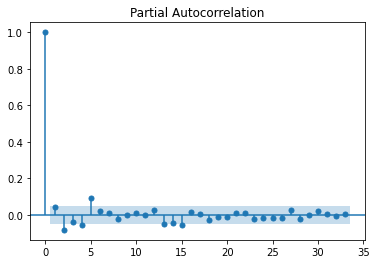

In [189]:
# отлично, для поиска параметров q, Q, p, P нарисуем график автокорреляции и частичной автокорреляции
# на графиках мы видим что графики практически одинаковые. Обучение не возможно, только подбор
tsaplots.plot_acf(ts_flat.dropna());
tsaplots.plot_pacf(ts_flat.dropna());

In [362]:
#обрат log()
def untransform(data):
    return np.exp(data)

### Вывод: решаем методом подбора dataset=ts.log

## Второй вариант
убрать тренд, гетероскедастичность, провести дифференцирование

In [430]:
ts_trend, k, b = extract_trend(ts)
ts_detrend = ts-ts_trend #вычитаем тренд

adf:  -2.602180946459534
p-value:  0.09254734744101417
Critical values:  {'1%': -3.4334209150252, '5%': -2.8628966110401337, '10%': -2.5674921939691435}
есть единичные корни, ряд не стационарен


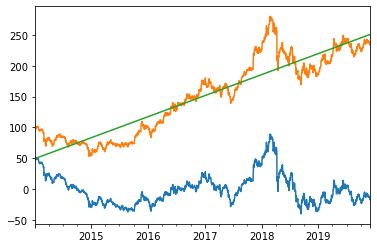

In [431]:
ts_detrend.plot(), ts.plot(), ts_trend.plot()
test_adfuler(ts_detrend)

In [432]:
#убираем отрицательные значения
min_value = int (abs(ts_detrend.min()))+1
ts_detrend_correct = ts_detrend+min_value

adf:  -2.6021809464595034
p-value:  0.0925473474410205
Critical values:  {'1%': -3.4334209150252, '5%': -2.8628966110401337, '10%': -2.5674921939691435}
есть единичные корни, ряд не стационарен


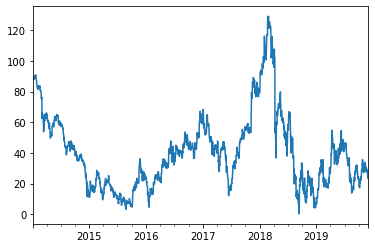

In [433]:
#проверяем еще раз
ts_detrend_correct.plot()
test_adfuler(ts_detrend_correct)

adf:  -3.0380510186057763
p-value:  0.03149049509695544
Critical values:  {'1%': -3.43342235783426, '5%': -2.8628972480890464, '10%': -2.567492533158371}
единичных корней нет, ряд стационарен


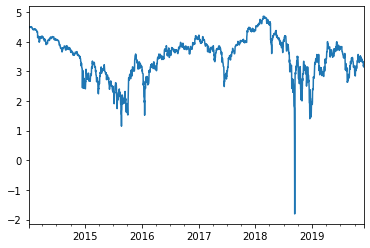

In [434]:
#убираем гетероскедастичность
ts_log = np.log(ts_detrend_correct)
ts_log.plot()
test_adfuler(ts_log)

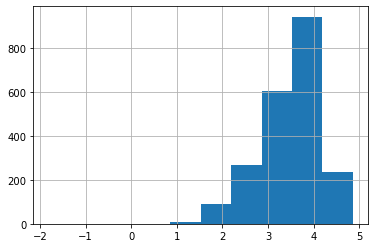

In [435]:
ts_log.hist();

adf:  -2.7817100440477147
p-value:  0.06093422613640971
Critical values:  {'1%': -3.4334281426535553, '5%': -2.862899802278988, '10%': -2.5674938931073803}
есть единичные корни, ряд не стационарен


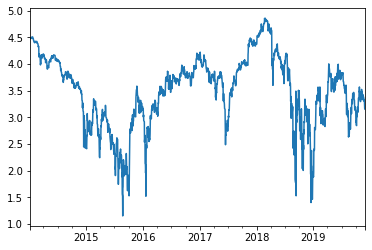

In [436]:
#убираем выброс
ts_log_correct = ts_log.copy().dropna()
ts_log_correct[ts_log_correct<1] = ts_log.mean()
ts_log_correct.plot()
test_adfuler(ts_log_correct)

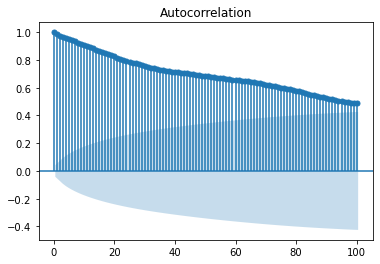

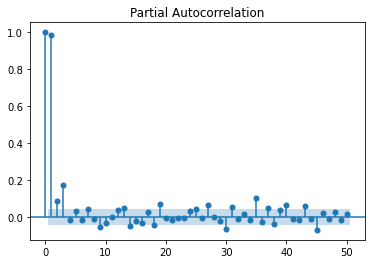

In [437]:
#смотрим автокорелляцию, сезонности нет, видим затухание
tsaplots.plot_acf(ts_log_correct, lags=100)
tsaplots.plot_pacf(ts_log_correct, lags=50);

adf:  -11.69453847033438
p-value:  1.6226135392029782e-21
Critical values:  {'1%': -3.43478213369545, '5%': -2.863497498654448, '10%': -2.567812151922376}
единичных корней нет, ряд стационарен


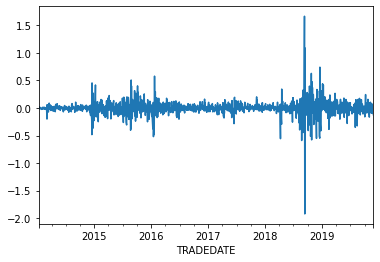

In [813]:
#дифференцируем
ts_diff = ts_log_correct.diff().dropna()
ts_diff.plot()
test_adfuler(ts_diff)

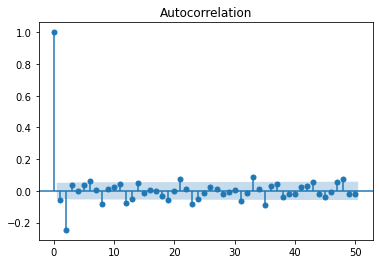

In [814]:
#смотрим автокорелляцию, сезонности нет
tsaplots.plot_acf(ts_diff, lags=50);

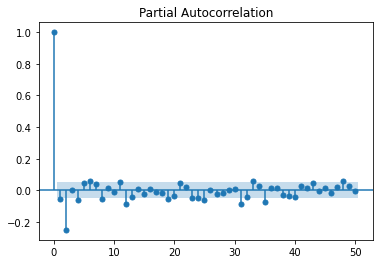

In [816]:
tsaplots.plot_pacf(ts_diff, lags=50);

In [438]:
#detrend, un log
def untransform(data):
    data = np.exp(data) #unlog
    data = data - min_value
    data = data + ts_trend
    return data


### Вывод: pdq неопределенно необходим подбор, dataset=ts_log_correct

In [382]:
#подбор параметров
pdq = (0, 0, 0)
# dataset=ts_diff
dataset=ts_log_correct
max_value=10
aic_old=0

In [383]:
for p in range(max_value):
    for d in range(max_value):
        for q in range(max_value):
            model = sarimax.SARIMAX(dataset, order=(p,d,q))
            try:
                res = model.fit()
            except Exception:
                continue
            aic = abs(res.aic)
            print (f'model({p},{d},{q}) AIC={res.aic}')
            if aic_old > aic or aic_old==0:
                pdq=(p,d,q)
                print ('best')
                aic_old=aic

ergenceWarning)
model(9,0,2) AIC=-4811.618796309067
D:\Anaconda3\envs\ts_summer\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
model(9,0,3) AIC=-4934.938963797751
D:\Anaconda3\envs\ts_summer\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
model(9,0,4) AIC=-4781.568231992846
D:\Anaconda3\envs\ts_summer\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
model(9,0,5) AIC=-4931.163404629131
D:\Anaconda3\envs\ts_summer\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
model(9,0,6) AIC=-4773.169034467786
D:\Anaconda3\envs\ts_summer\lib\site-packages\st

In [384]:
pdq, aic_old

((0, 9, 6), 5.080121751462002)

### Подбор дал следующий результат pdq= (8, 0, 1) aic=20, dataset=ts_log (версия1)
### Подбор дал следующий результат pdq= (5, 7, 8) aic=2.4, dataset=ts_diff (версия2)
### Подбор дал следующий результат pdq= (7, 6, 4) aic=1.3, dataset=ts_log_correct (версия2)
### Подбор дал следующий результат pdq= (0, 9, 6) aic=5.08, dataset=ts_log_correct (версия3)

### третий вариант с помощью библиотеки вычисляем тренд

adf:  -11.915140702497721
p-value:  5.185922008188948e-22
Critical values:  {'1%': -3.4334722331103045, '5%': -2.86291926951847, '10%': -2.5675042582416148}
единичных корней нет, ряд стационарен


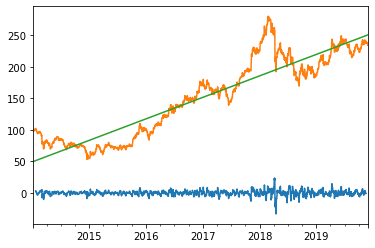

In [375]:
#с помощью библиотеки вычисляем тренд
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(ts, period=30) #90
#вычитаем тренд, получили стационарный ряд
ts_detrend = ts - decomp.trend
ts_detrend.plot(), ts.plot(), ts_trend.plot()
test_adfuler(ts_detrend)


In [376]:
#убираем отрицательные значения
min_value = int (abs(ts_detrend.min()))+1
ts_detrend_correct = ts_detrend+min_value

adf:  -11.91514070249778
p-value:  5.185922008187423e-22
Critical values:  {'1%': -3.4334722331103045, '5%': -2.86291926951847, '10%': -2.5675042582416148}
единичных корней нет, ряд стационарен


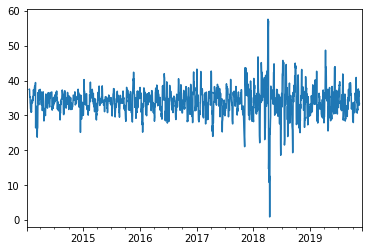

In [377]:
#проверяем еще раз
ts_detrend_correct.plot()
test_adfuler(ts_detrend_correct)

adf:  -17.445127673726493
p-value:  4.6859339556747496e-30
Critical values:  {'1%': -3.433444163815172, '5%': -2.86290687612843, '10%': -2.567497659501288}
единичных корней нет, ряд стационарен


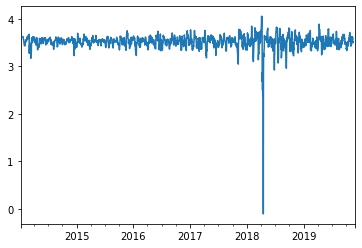

In [378]:
#убираем гетероскедастичность
ts_log = np.log(ts_detrend_correct)
ts_log.plot()
test_adfuler(ts_log)

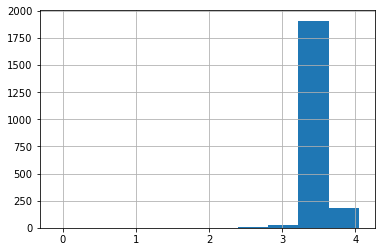

In [379]:
ts_log.hist();

adf:  -11.791969339609025
p-value:  9.778022703363556e-22
Critical values:  {'1%': -3.4334722331103045, '5%': -2.86291926951847, '10%': -2.5675042582416148}
единичных корней нет, ряд стационарен


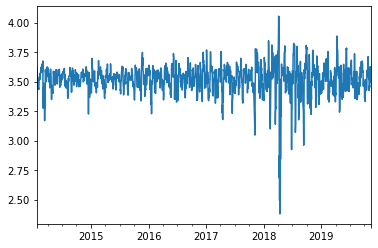

In [380]:
#убираем выброс
ts_log_correct = ts_log.copy().dropna()
ts_log_correct[ts_log_correct<2] = ts_log.mean()
ts_log_correct.plot()
test_adfuler(ts_log_correct)

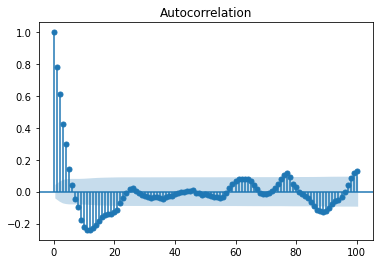

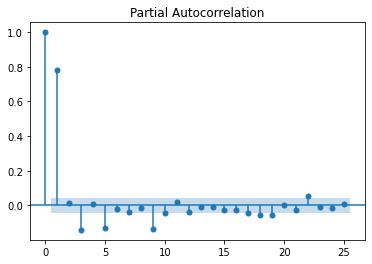

In [381]:
#смотрим автокорелляцию, видим затухание
tsaplots.plot_acf(ts_log_correct, lags=100)
tsaplots.plot_pacf(ts_log_correct, lags=25);

D,d=(0,0)<p>
P,p=(0,3)

In [403]:
#detrend, un log
def untransform(data):
    data = np.exp(data) #unlog
    data = data - min_value
    data = data + decomp.trend
    return data

In [12]:
import load_dataset
import sys
from pathlib import Path

sys.path.append(str(Path().cwd().parent))
from plotting import plot_ts
dataset = load_dataset.Dataset('data/dataset/')
data = dataset['alcohol_sales.csv']

In [13]:
len_test = int (len(data)*0.8) #80% обучающая выборка
ts, ts_test = data[:len_test], data[len_test:]

adf:  1.2435484536657533
p-value:  0.9962733743090773
Critical values:  {'1%': -3.4578942529658563, '5%': -2.8736593200231484, '10%': -2.573228767361111}
есть единичные корни, ряд не стационарен


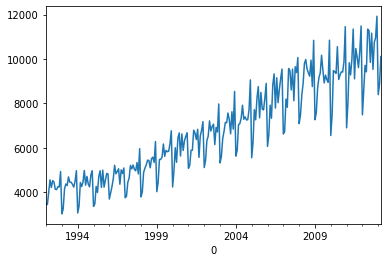

In [145]:
ts.plot()
test_adfuler(ts)

adf:  -0.5332842833271114
p-value:  0.8853560138905703
Critical values:  {'1%': -3.4578942529658563, '5%': -2.8736593200231484, '10%': -2.573228767361111}
есть единичные корни, ряд не стационарен


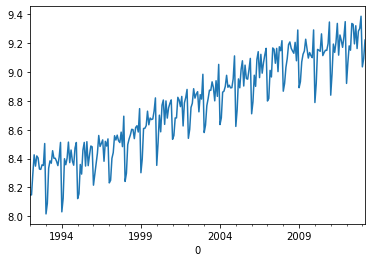

In [147]:
ts_log = np.log(ts)
ts_log.plot()
test_adfuler(ts_log)

adf:  -1.7706758761545063
p-value:  0.3951143895768252
Critical values:  {'1%': -3.458128284586202, '5%': -2.873761835239286, '10%': -2.5732834559706235}
есть единичные корни, ряд не стационарен


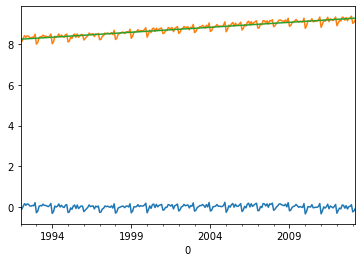

In [149]:
ts_trend, k, b = extract_trend(ts_log)
ts_detrend = ts_log-ts_trend #вычитаем тренд
ts_detrend.plot(), ts_log.plot(), ts_trend.plot()
test_adfuler(ts_detrend)

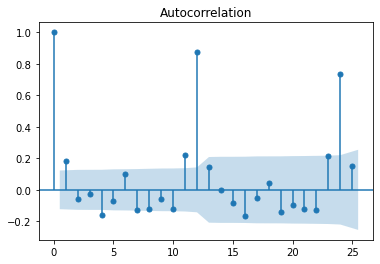

In [151]:
#сезонность 12
tsaplots.plot_acf(ts_detrend);

adf:  -3.4701292262979235
p-value:  0.008788207611623095
Critical values:  {'1%': -3.4582467982399105, '5%': -2.8738137461081323, '10%': -2.5733111490323846}
единичных корней нет, ряд стационарен


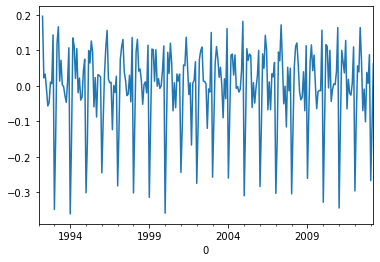

In [152]:
period=12
season = extract_seasonality(ts_detrend, period=period)
ts_deseason = ts_detrend - season
ts_deseason.plot()
test_adfuler(ts_deseason)

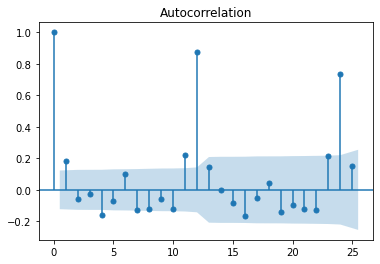

In [153]:
ts_deseason = ts_detrend
tsaplots.plot_acf(ts_deseason.dropna(), lags=25);

In [154]:
ts_diff = ts_deseason.diff(12).dropna()

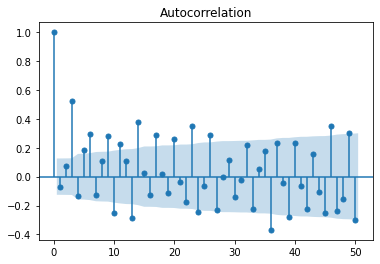

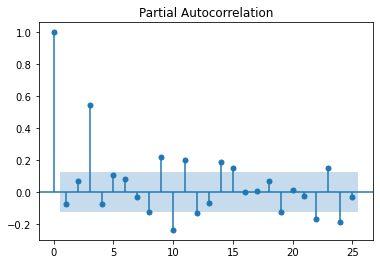

In [155]:
tsaplots.plot_acf(ts_diff, lags=50);
tsaplots.plot_pacf(ts_diff, lags=25);

In [77]:
P,p=0,0
D,d=1,1
Q,q=0,0

In [164]:
#detrend, un log
def untransform(data):
    return np.exp(data)

## строим модель SARIMA

In [11]:
pdq = (0, 1, 0)
PDQ = (0, 1, 0, 12)
dataset=ts_log

NameError: name 'ts_log' is not defined

In [157]:
model = sarimax.SARIMAX(dataset, order=pdq, seasonal_order=PDQ)

D:\Anaconda3\envs\ts_summer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
D:\Anaconda3\envs\ts_summer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [158]:
res = model.fit()
print (f'AIC={res.aic}')

AIC=-570.7226005702489


In [159]:
preds=res.forecast(len(ts_test))
# preds = res.predict(start='2019-11-26', end='2021-05-21')

<AxesSubplot:>

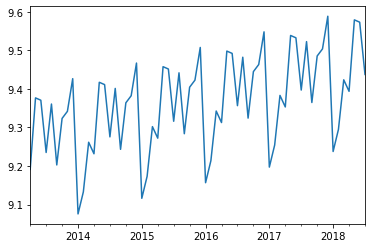

In [160]:
preds.plot()

In [165]:
plotting.plot_ts(ts_test, untransform(dataset), untransform(preds), legends=['ts_test','dataset','preds']);
# plotting.plot_ts(ts, ts_test, np.exp(ts_log)-min_value+decomp.trend, np.exp(preds)-min_value+decomp.trend, legends=['ts','ts_test','ts_log','preds']);

Loading BokehJS ...

## Пробуем auto_arima

In [9]:

from pmdarima import auto_arima

In [14]:
model = auto_arima(
     ts, start_p=0, start_q=0,
     max_p=3, max_q=3,
     start_P=0, start_Q=0, d=1,
     seasonal=False,trace=True,
     error_action='ignore',
     suppress_warnings=True,
     stepwise=False)

Fit ARIMA: order=(0, 1, 0); AIC=4279.433, BIC=4286.507, Fit time=0.408 seconds
Fit ARIMA: order=(0, 1, 1); AIC=4144.126, BIC=4154.738, Fit time=0.149 seconds
Fit ARIMA: order=(0, 1, 2); AIC=4142.958, BIC=4157.107, Fit time=0.198 seconds
Fit ARIMA: order=(0, 1, 3); AIC=4142.569, BIC=4160.256, Fit time=0.366 seconds
Fit ARIMA: order=(1, 1, 0); AIC=4237.743, BIC=4248.355, Fit time=0.046 seconds
Fit ARIMA: order=(1, 1, 1); AIC=4143.531, BIC=4157.680, Fit time=0.367 seconds
Fit ARIMA: order=(1, 1, 2); AIC=4143.467, BIC=4161.154, Fit time=0.312 seconds
Fit ARIMA: order=(1, 1, 3); AIC=4123.545, BIC=4144.769, Fit time=0.745 seconds
Fit ARIMA: order=(2, 1, 0); AIC=4208.285, BIC=4222.434, Fit time=0.156 seconds
Fit ARIMA: order=(2, 1, 1); AIC=4143.197, BIC=4160.883, Fit time=0.320 seconds
Fit ARIMA: order=(2, 1, 2); AIC=4145.042, BIC=4166.266, Fit time=0.565 seconds
Fit ARIMA: order=(2, 1, 3); AIC=4104.740, BIC=4129.502, Fit time=2.901 seconds
Fit ARIMA: order=(3, 1, 0); AIC=4206.514, BIC=4224.2

In [19]:
'Arima'+str(model.order)

'Arima(3, 1, 3)'

In [654]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 1401
Model:                 ARIMA(3, 1, 3)   Log Likelihood                1024.601
Method:                       css-mle   S.D. of innovations              0.116
Date:                Sat, 29 May 2021   AIC                          -2033.201
Time:                        18:25:23   BIC                          -1991.242
Sample:                             1   HQIC                         -2017.516
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.002      0.118      0.906      -0.004       0.005
ar.L1.D.y     -0.3685      0.110     -3.363      0.001      -0.583      -0.154
ar.L2.D.y     -0.0368      0.084     -0.437      0.662      -0.202       0.128
ar.L3.D.y     -0.3648      0.091     -4.025      0.000      -0.542      -0.187
ma.L1.D.y      0.0976      0.102      0.955      0.340      -0.103       0.298
ma.L2.D.y     -0.2260      0.072     -3.142      0.002      -0.367      -0.085
ma.L3.D.y      0.4568      0.095      4.786      0.000       0.270       0.644
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1893           -0.0000j            1.1893           -0.5000
AR.2            0.5442           -1.4172j            1.5181           -0.1916
AR.3            0.5442           +1.4172j            1.5181            0.1916
MA.1           -1.1050           -0.0000j            1.1050           -0.5000
MA.2            0.7999           -1.1582j            1.4076           -0.1538
MA.3            0.7999           +1.1582j            1.4076            0.1538
-----------------------------------------------------------------------------
"""

In [687]:
res = model.fit(ts_test)

In [688]:
preds=res.predict(len(ts_test))

In [689]:
preds=pd.Series(preds, index=ts_test.index)

In [690]:
plotting.plot_ts(ts, ts_test, np.exp(ts_log)-min_value+decomp.trend, preds-min_value, legends=['ts','ts_test','ts_log','preds']);

Loading BokehJS ...